In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import util
from sklearn import manifold, datasets
from sklearn.decomposition import PCA


# Important: utiliser les données prétraitées
csv_path = 'data/dataframe.csv'

In [25]:
df = pd.read_csv(csv_path)
df.head()
classes = [
    'Another party (please specify)',
    'Bloc Qu<e9>b<e9>cois',
    'Conservative Party',
    "Don't know/ Prefer not to answer",
    'Green Party',
    'Liberal Party',
    'ndp',
    "People's Party"
]
X = df.iloc[:,1:-1]
y = df.iloc[:,-1]

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 30,shuffle = True)

# Premier essai avec des arbres de décision 

In [29]:
from sklearn.tree import DecisionTreeClassifier
clf_first = DecisionTreeClassifier(max_depth=5, random_state=0)

clf_first.fit(X_train, y_train)

y_pred = clf_first.predict(X_test)

In [30]:
from sklearn.metrics import accuracy_score

print('Test score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred)))
y_pred_train = clf_first.predict(X_train)

print('Train score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_train, y_pred_train)))

Test score with criterion gini index: 0.4026
Train score with criterion gini index: 0.3999


### Analyse: 

Le score est pas super bon mais au moins on n'overfit pas : la différence entre le score d'entraînement et le score de test est faible.
Essayons de trouver la profondeur optimale pour éviter l'overfit et avoir le meilleur score

In [31]:
depth_clfs = [DecisionTreeClassifier(max_depth=k, random_state=0) for k in range(1,30)]
accuracy_train = []
accuracy_test = []
for clf in depth_clfs:
    clf.fit(X_train, y_train)
    accuracy_train.append(clf.score(X_train, y_train))
    accuracy_test.append(clf.score(X_test, y_test))


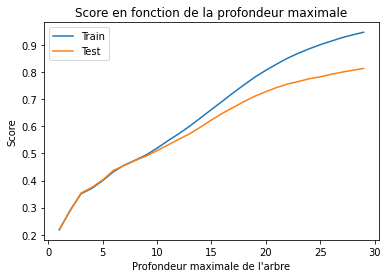

Le meilleur score sans overfit semble être pour une profondeur de 10 qui nous donne un score de 0.5310354023601573


In [36]:
plt.plot([k for k in range(1,30)],accuracy_train,label='Train')
plt.plot([k for k in range(1,30)],accuracy_test,label='Test')

plt.legend()
plt.title("Score en fonction de la profondeur maximale")
plt.xlabel("Profondeur maximale de l'arbre")
plt.ylabel("Score")
plt.show()

print(f"Le meilleur score sans overfit semble être pour une profondeur de 10 qui nous donne un score de {accuracy_test[10]}")
meilleur_clf = depth_clfs[10]


### Analyse: 

Les deux courbes commencent à se séparer autour d'une profondeur maximale de 10. On retiendra donc le classifieur de profondeur 10 pour notre problème. 

Essayons maintenant de jeter un oeil à notre matrice de confusion:

<Figure size 1152x864 with 0 Axes>

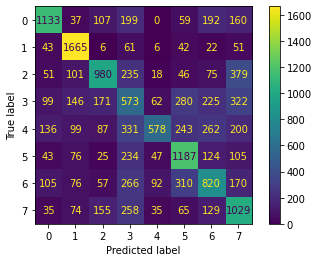

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [37]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(meilleur_clf,X_test,y_test)
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

### Analyse:

On constate que le gros de l'incertitude réside chez les éléments qui eux mêmes ne sont pas certains de leur orientation politique ou encore sur les partis moins clivants et plus centristes comme le parti vert et dans une moindre mesure le NDP. Pour d'auters partis plus spécifiques comme le Bloc ou encore les classiques conservateur/libéral, le taux de vrais positifs est beaucoup plus élevé.

# Forêts aléatoires :

In [38]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score, f1_score

clf_forest = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
clf_forest.fit(X_train, y_train)


y_forest_pred_test = clf_forest.predict(X_test)
score_test_forest = accuracy_score(y_test, y_forest_pred_test)
f1_test_forest = f1_score(y_test, y_forest_pred_test,average="macro")

y_forest_pred_train = clf_forest.predict(X_train)
score_train_forest = accuracy_score(y_train, y_forest_pred_train)
f1_test_forest = f1_score(y_train, y_forest_pred_train,average="macro")


print(f"clf_forest test accuracy score : {score_test_forest} \n\
    clf_forest test f1 score : {f1_test_forest}")
print(f"clf_forest train accuracy score : {score_train_forest}\n\
    clf_forest train f1 score : {f1_test_forest}")

clf_forest test accuracy score : 0.4283618907927195 
    clf_forest test f1 score : 0.3796463076427288
clf_forest train accuracy score : 0.42439951327654896
    clf_forest train f1 score : 0.3796463076427288


<Figure size 1152x864 with 0 Axes>

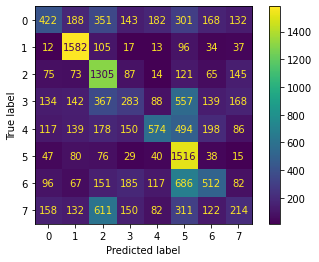

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(clf_forest,X_test,y_test)
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

### Analyse:

Avec un score de seulement 42.8% on a un classifieur qui n'est clairement pas bon, il nous faut donc jouer avec les hyperparamètres pour essayer de trouver la meilleure version de ce dernier

In [39]:
parameters = {
    "n_estimators":[50,100,250],
    "max_depth":[12,24,32,None]
    
}

from sklearn.model_selection import GridSearchCV
cv = GridSearchCV(clf_forest,parameters,cv=6)
cv.fit(X_train, y_train)

GridSearchCV(cv=6,
             estimator=RandomForestClassifier(max_depth=2, random_state=0),
             param_grid={'max_depth': [12, 24, 32, None],
                         'n_estimators': [50, 100, 250]})

In [40]:
print(f'Best parameters are: {cv.best_params_}')
print("\n")
mean_score = cv.cv_results_['mean_test_score']
std_score = cv.cv_results_['std_test_score']
params = cv.cv_results_['params']
for mean,std,params in zip(mean_score,std_score,params):
    print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

Best parameters are: {'max_depth': 32, 'n_estimators': 250}


0.619 + or -0.004 for the {'max_depth': 12, 'n_estimators': 50}
0.621 + or -0.004 for the {'max_depth': 12, 'n_estimators': 100}
0.624 + or -0.003 for the {'max_depth': 12, 'n_estimators': 250}
0.838 + or -0.005 for the {'max_depth': 24, 'n_estimators': 50}
0.841 + or -0.006 for the {'max_depth': 24, 'n_estimators': 100}
0.842 + or -0.006 for the {'max_depth': 24, 'n_estimators': 250}
0.857 + or -0.005 for the {'max_depth': 32, 'n_estimators': 50}
0.859 + or -0.005 for the {'max_depth': 32, 'n_estimators': 100}
0.86 + or -0.004 for the {'max_depth': 32, 'n_estimators': 250}
0.858 + or -0.003 for the {'max_depth': None, 'n_estimators': 50}
0.859 + or -0.004 for the {'max_depth': None, 'n_estimators': 100}
0.86 + or -0.005 for the {'max_depth': None, 'n_estimators': 250}


In [41]:
best_clf_forest = RandomForestClassifier(n_estimators=250, max_depth=32, random_state=10)
best_clf_forest.fit(X_train, y_train)

y_pred_test = best_clf_forest.predict(X_test)
score_test = accuracy_score(y_test, y_pred_test)
f1_test = f1_score(y_test, y_pred_test,average="macro")

y_pred_train = best_clf_forest.predict(X_train)
score_train = accuracy_score(y_train, y_pred_train)
f1_test = f1_score(y_train, y_pred_train,average="macro")


print(f"best clf_forest test accuracy score : {score_test} \n\
    best clf_forest test f1 score : {f1_test}")
print(f"best clf_forest train accuracy score : {score_train}\n\
    best clf_forest train f1 score : {f1_test}")


best clf_forest test accuracy score : 0.8779918661244083 
    best clf_forest test f1 score : 0.9913112081701649
best clf_forest train accuracy score : 0.9913156534929075
    best clf_forest train f1 score : 0.9913112081701649


<Figure size 1152x864 with 0 Axes>

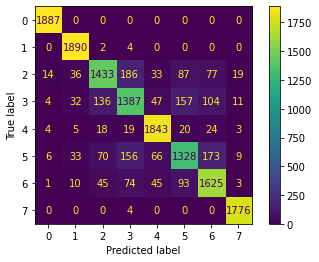

(0,) : Another party (please specify)
(1,) : Bloc Qu<e9>b<e9>cois
(2,) : Conservative Party
(3,) : Don't know/ Prefer not to answer
(4,) : Green Party
(5,) : Liberal Party
(6,) : ndp
(7,) : People's Party


In [42]:
plt.figure(figsize=(16,12))
ConfusionMatrixDisplay.from_estimator(best_clf_forest,X_test,y_test)
plt.show()

for index, classe in np.ndenumerate(classes):
    print(f"{index} : {classe}")

### Analyse:

A première vue, au vu de la différence entre le score parfait sur l'ensemble d'entraînement et le score sur l'ensemble de test très élevé, on pourrait se dire que les forêts aléatoires, déjà propices à l'overfitting, sont en train de violemment overfit mais ce n'est pas vraiment le cas comme on peut le voir avec les excellents résultats dans la matrice de confusion. De plus les coefficients obtenus pour nos forets aléatoires ont été obtenues par une recherche en grille ET pour être absolument certain une validation croisée 10-fold! Cela fait que le temps de calcul a été très long (de l'ordre de la demi-heure) mais cela nous assure que la forêt ne capte pas des données trop spécifiques à un sous ensemble particulier de l'ensemble des données.

### Résultat final avec les forêts aléatoires: 
Accuracy : 87.8%
F1-score : 0.9914 (curieusement élevé)

# Discussion sur l'explicabilité des arbres de décision: 

Un des avantages les plus importants des arbres de décision et donc par extension des forêts aléatoires est **l'explicabilité et l'interprétabilité des résultats** surtout lorsque comparé à des modèles plus complexes comme les réseaux de neurones qui fonctionnent en "boîte noire". 

Dans le cas particulier des élections par exemple, cette explicabilité est d'autant plus pertinente qu'il s'agit de données importantes pour la vie de millions de citoyens en ce qui peut concerner leur intention de vote: les différentes prédictions des instituts de sondages peuvent pousser un individu hésitant à voter pour un autre candidat à la recherche du "vote utile". Il est donc important qu'en cas de problèmes, l'on puisse se plonger dans les entrailles d'un tel classifieur pour comprendre ce qui s'y passe.

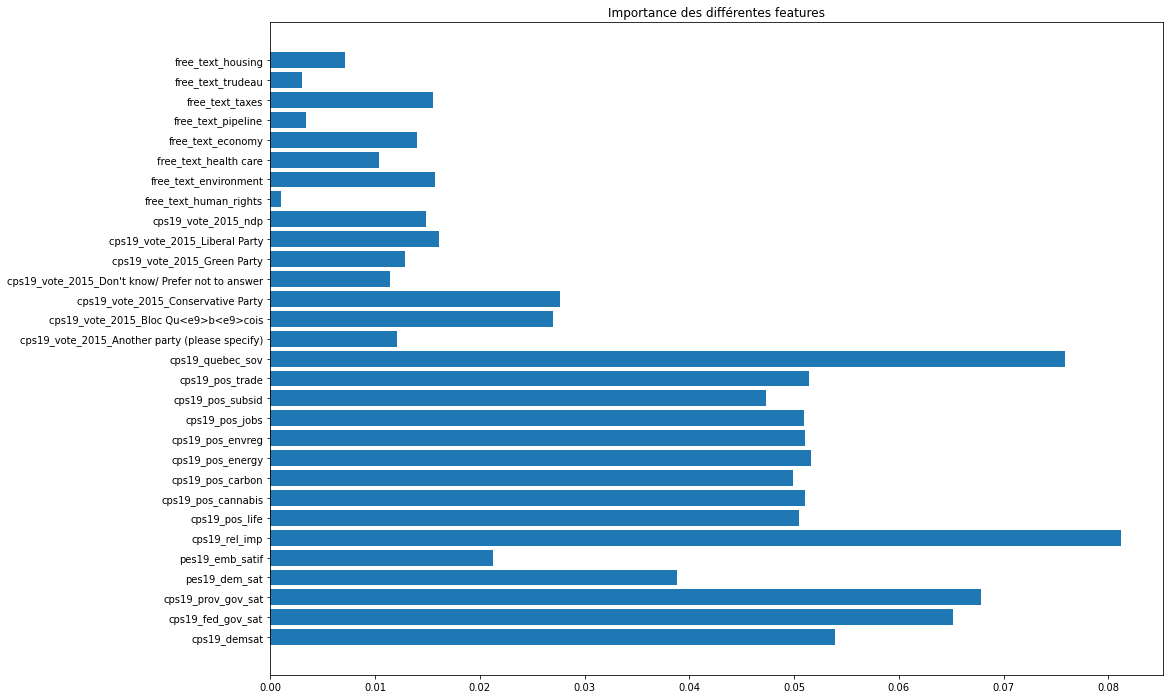

In [43]:
importances = best_clf_forest.feature_importances_
colonnes = df.columns
n_importances = np.arange(len(importances))

fig, ax = plt.subplots(figsize=(16,12)) 
ax.barh(n_importances, importances)
ax.set_yticks(n_importances)
ax.set_yticklabels(colonnes[1:-1],minor=False)
plt.title("Importance des différentes features")
plt.show()

### Analyse:

On peut d'ores et déjà constater que parmi toutes les questions, certaines semblent particulièrement sortir du lot : 
c'est notamment le cas pour **cps19_quebec_sov** qui en toute logique est un excellent indicateur d'une personne vivant au Québec et donc la plupart du temps, votant pour le Bloc Québecois. Un autre, plus surprenant est **cps_19_rel_imp** qui correspond à l'importance de la religion dans la vie de la personne sondée. Ce graphique seul ne nous permet cependant pas de dire immédiatement dans quel sens penche cette importance : est ce que les personnes religieuses votent plus conservateur (soupçonné personnellement) ou est ce qu'ils sont indicateurs d'immigrants et qui auraient alors plus intérêt à voter libéral? Le fait est que peu importe la réponse, les arbres de décision nous ont permis de souligner cette singularité plus qu'intéressante! 
Après ces deux attributs, les attributs sur la satisfaction du gouvernement provincial (**cps19_prov_gov_sat**) et fédéral(**cps19_fed_gov_sat**) semblent également être importants dans la décision et encore une fois cela semble logique : Ceux qui sont satisfaits du premier ministre actuel vont voter pour le même parti, ceux qui ne le sont pas vont voter pour un parti différent.

In [9]:
# %pip install pydot graphviz
# import os
# from sklearn.tree import export_graphviz
# import six
# import pydot
# from sklearn import tree
# import graphviz
# dotfile = six.StringIO()
# i_tree = 0
# tree_in_forest = best_clf_forest.estimators_[0]
# dotData = tree.export_graphviz(tree_in_forest,out_file=None,
#     feature_names=df.columns[1:-1],
#     filled=True,
#     rounded=True)
# graph = graphviz.Source(dotData, format="png")
# graph

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'C:\Users\Melvin\AppData\Local\Programs\Python\Python37\python.exe -m pip install --upgrade pip' command.


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH